In [1]:
########################################################################################################

***** INSTRUCTIONS TO RUN THE CODE *****

These are a collated set of codes,
Some parts of the code have been written in R programming.

In order to see the results, please run the code from 'Loading processed data' in 
'Writing and loading processed data' section.

The 'Processed_data' has been shared along with the original data. 

########################################################################################################

In [ ]:
##########################################
# Importing packages
##########################################

In [78]:
# Data analysis packages

import pandas as pd
import numpy as np

# Machine learning packages

import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing, linear_model, multiclass, ensemble, tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Plotting packages

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc_curve
import seaborn as sns; sns.set()

In [ ]:
#########################################
# Setting Plot size for all plots
#########################################

In [80]:
plt.figure('Reference Plot')
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 7
plt.rcParams['figure.figsize'] = fig_size

<Figure size 576x360 with 0 Axes>

In [ ]:
##########################################
# Importing data
##########################################

In [47]:
data = pd.read_csv('/home/Shivambhardwaj/Documents/Aegis/Machine Learning/ML Project/online retail/Online Retail new2.csv',
                   parse_dates=['InvoiceDate'])

In [ ]:
##########################################
# Data Preparation
##########################################

In [48]:
# Dropping NA's

data = data.dropna()
data.reset_index(drop=True, inplace=True)

In [49]:
# Quantity_returned and Price_returned

data.loc[:,'Quantity_returned'] = [0]*len(data)
data.loc[:,'Price_returned'] = [0]*len(data)

for i in range(len(data)):
    quan = data.loc[i,'Quantity']
    nquan = data.loc[i,'Quantity_returned']
    pric = data.loc[i,'UnitPrice']
    npric = data.loc[i,'Price_returned']
    if quan < 0:
        quan, nquan = nquan, quan
        pric, npric = npric, pric
        data.loc[i,'Quantity'] = quan
        data.loc[i,'Quantity_returned'] = abs(nquan)
        data.loc[i,'UnitPrice'] = pric
        data.loc[i,'Price_returned'] = abs(npric)

In [50]:
# Total_Spent, Total_returned and Revenue_contri

data.loc[:,'Total_Spent'] = data.Quantity*data.UnitPrice
data.loc[:,'Total_returned'] = data.Quantity_returned*data.Price_returned
data.loc[:,'Revenue_contri'] = (data.loc[:,'Total_Spent'] - data.loc[:,'Total_returned'])*data.loc[:,'Profit_Margin(%)']/100

In [51]:
# Customer grouping

nd = data.groupby(['CustomerID']).agg({'Quantity':'sum',
                                       'Total_Spent':'sum',
                                       'Quantity_returned':'sum',
                                       'Total_returned':'sum',
                                       'Revenue_contri':'sum',
                                       'InvoiceNo':'nunique',
                                       'Country':'nunique'})

n_data = nd.reset_index()
n_data.loc[:,'Revenue_contri'] = n_data.loc[:,'Revenue_contri'].round(2)

In [52]:
# Duration in months

months = []

for i in n_data.CustomerID:
    a = data.InvoiceDate[data.CustomerID == i]
    a.reset_index(drop = True, inplace=True)
    b = (a[len(a)-1] - a[0])/30
    months.append(b.days)

for i in range(len(months)):
    if months[i] == 0:
        months[i] += 1

n_data.loc[:,'Duration_months'] = months

In [ ]:
##############################
# Collated code from R
##############################

In [ ]:
library(RMySQL)
mydb = dbConnect(MySQL(),user = "root",password = "root", dbname = "Rdbnew",host="127.0.0.1",
                 port=3306)
dbListTables(mydb)
data1=read.csv("Online Retail new2.csv")
dbWriteTable(mydb,name = "OL2",value = data1)
newdata=as.data.frame(dbReadTable(mydb,'OL1'))

detach("package:RMySQL", unload=TRUE)

#install.packages("sqldf")
library(sqldf)
View(data1)
UC=unique(df1$CustomerID)
View(UC)

COC= sqldf('SELECT * FROM data1 WHERE CustomerID IN 
           ( SELECT distinct CustomerID FROM data1 
           GROUP BY CustomerID HAVING COUNT(distinct Country) > 1 )')
View(COC)

CC= sqldf('select count(distinct Category) as count_category,CustomerID from data1 group by CustomerID')
View(CC)

NOP=sqldf('select InvoiceNo,count(Category) as NOP,CustomerID from data1 group by InvoiceNo')
View(NOP)

SDC=sqldf('Select stdev(Category),CustomerID from NOP group by CustomerID')

SDI=sqldf('Select stdev(distinct(InvoiceDate)),CustomerID from data1 group by CustomerID')
View(SDI)

In [ ]:
##########################################
# Writing and loading processed data
##########################################

In [ ]:
# Writing processed data

from pandas import ExcelWriter
writer = ExcelWriter('Processed_data.xlsx')
n_data_ori.to_excel(writer, 'Sheet1', index=False)
writer.save()

In [ ]:
# Loading processed data

n_data = pd.read_csv('/home/Shivambhardwaj/Documents/Aegis/Machine Learning/ML Project/online retail/Processed_data.csv')
n_data_ori = pd.read_csv('/home/Shivambhardwaj/Documents/Aegis/Machine Learning/ML Project/online retail/Processed_data.csv')
columns = n_data_ori.columns[1:]

# Scaling of data

n_data = preprocessing.scale(n_data.iloc[:,1:])
new = pd.DataFrame(data=n_data)
n_data = preprocessing.normalize(new)
new = pd.DataFrame(data=n_data, columns=columns)
n_data = new

In [ ]:
##########################################
# Correlation analysis
##########################################

In [82]:
# Correlation between features

cor = n_data_ori.iloc[:, 1:].corr()

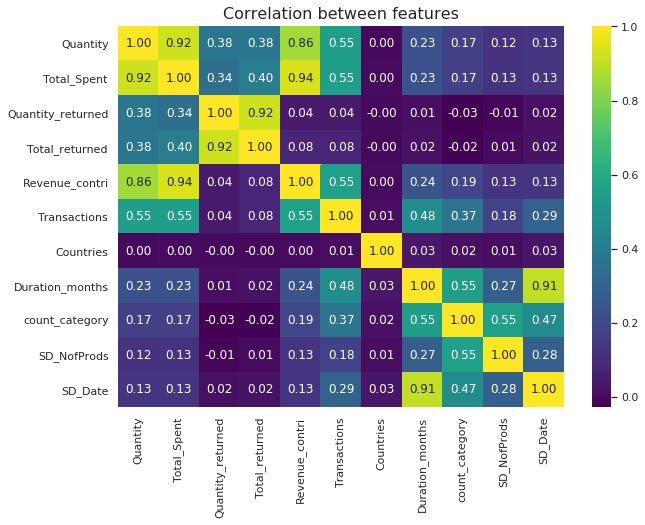

In [83]:
# Plotting correlation

plt.plot()
sns.heatmap(cor, cmap='viridis', annot=True, fmt='.2f')
plt.title('Correlation between features', fontdict={'fontsize':16}, pad=7.5)
plt.show()

In [ ]:
##########################################
# Determining optimal number for K
##########################################

In [84]:
# k-means determine k

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(n_data.iloc[:,[4,5,7]])
    Sum_of_squared_distances.append(km.inertia_)

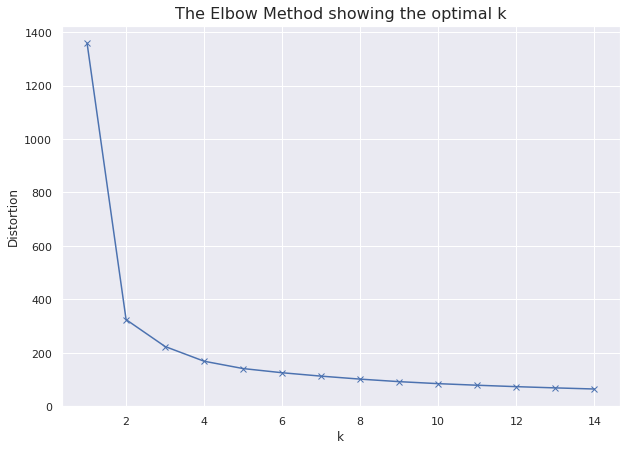

In [85]:
# Plot the elbow curve

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k', fontdict={'fontsize':12})
plt.ylabel('Distortion', fontdict={'fontsize':12})
plt.title('The Elbow Method showing the optimal k', fontdict={'fontsize':16}, pad=7.5)
plt.show()

In [ ]:
##########################################
# Clustering and labelling data
##########################################b

In [86]:
# k-means clustering

km = KMeans(n_clusters=4, max_iter=300, random_state=33)
km = km.fit(n_data.iloc[:,[4,5,7]])
labels = km.predict(n_data.iloc[:,[4,5,7]])

In [87]:
# labelling data

n_data_ori.loc[:,'Labels'] = labels

In [88]:
# cluster counts

n_data_ori.groupby(['Labels']).agg({'CustomerID':'count'})

,CustomerID
Labels,
0,1030
1,2290
2,599
3,453


In [ ]:
##########################################
# Clusters plot
##########################################

In [89]:
# Dimensionality reduction using PCA

pca = PCA(n_components=2).fit(n_data.iloc[:,[4,5,7]])
pca_2d = pca.transform(n_data.iloc[:,[4,5,7]])

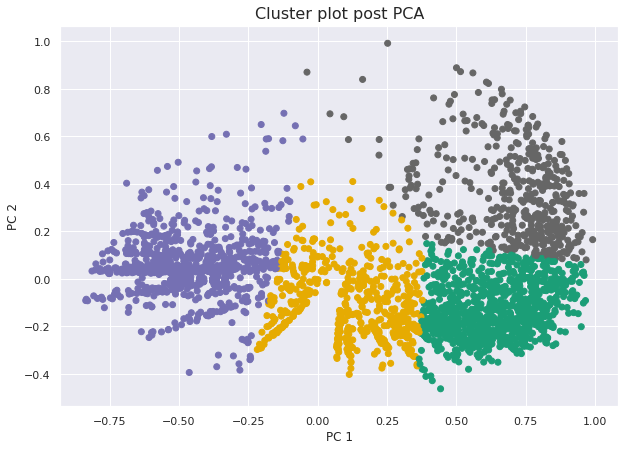

In [90]:
# Two dimensional scatter plot of clusters

plt.plot()
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels, cmap='Dark2')
plt.title('Cluster plot post PCA', fontdict={'fontsize':16}, pad=7.5)
plt.xlabel('PC 1', fontdict={'fontsize':12})
plt.ylabel('PC 2', fontdict={'fontsize':12})
plt.show()

In [ ]:
# Analysing the clusters

lab = n_data_ori.groupby(['Labels']).agg({'Revenue_contri':'mean',
                                    'Transactions':'mean',
                                    'Duration_months':'mean'})
lab.Revenue_contri = lab.Revenue_contri.round(3)

for i in lab.index:
    cnt = lab.Revenue_contri[lab.Revenue_contri[i] >= lab.Revenue_contri].count()
    if cnt == 1:
        n_data_ori.Labels[n_data_ori.Labels == i] = 'Low'
    if cnt == 2:
        n_data_ori.Labels[n_data_ori.Labels == i] = 'Below Avg'
    if cnt == 3:
        n_data_ori.Labels[n_data_ori.Labels == i] = 'Above Avg'
    if cnt == 4:
        n_data_ori.Labels[n_data_ori.Labels == i] = 'High'

In [ ]:
#########################################
# Building model to predict CLV
#########################################

In [96]:
# Splitting data into train and test

train, test = train_test_split(n_data_ori, test_size=0.3, random_state=20,
                               stratify=n_data_ori.iloc[:,-1], shuffle=True)
test_y, test_lab = test.iloc[:, 1:-1], test.iloc[:, -1]

# Splitting train set to get cross-validation set

X, y = train.iloc[:,1:-1], train.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20,
                                                    stratify=y, shuffle=True)

In [ ]:
# Scaling data

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
test_y = scaler.transform(test_y)

In [98]:
# Building model

#classifier = multiclass.OneVsRestClassifier(linear_model.LogisticRegression())
#classifier = ensemble.RandomForestClassifier(random_state=33)
classifier = tree.DecisionTreeClassifier(random_state=0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [99]:
# Predictions on Cross-validation set

y_pred = classifier.predict(X_test)
probs = classifier.predict_proba(X_test)

In [103]:
# Predictions on Test set

y_pred2 = classifier.predict(test_y)
probs2 = classifier.predict_proba(test_y)

In [ ]:
#########################################
# Performance metrics
#########################################

In [100]:
# Classification report Cross-validation set

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   Above Avg       0.94      0.79      0.86        42
   Below Avg       0.93      0.96      0.95        72
        High       0.88      0.94      0.91        32
         Low       0.98      0.99      0.98       160

   micro avg       0.95      0.95      0.95       306
   macro avg       0.93      0.92      0.92       306
weighted avg       0.95      0.95      0.95       306



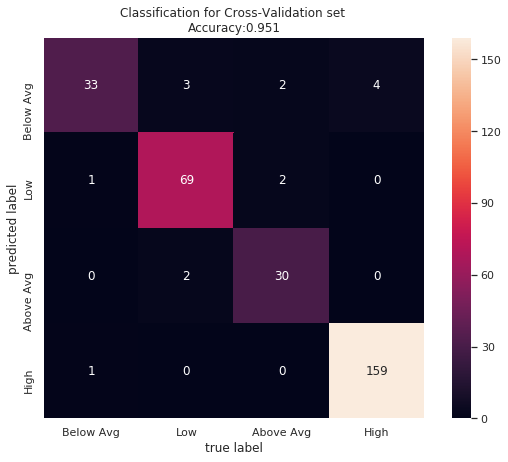

In [105]:
# Plotting confusion matrix for Cross-validation set

mat = metrics.confusion_matrix(y_test, y_pred)
index = ['Below Avg', 'Low', 'Above Avg', 'High']
column = ['Below Avg', 'Low', 'Above Avg', 'High']
mat = pd.DataFrame(mat, index=index, columns=column)

plt.plot()
sns.heatmap(mat, square=True, annot=True, fmt='d')
plt.title('Classification for Cross-Validation set \nAccuracy:{0:.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

/home/rajat/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


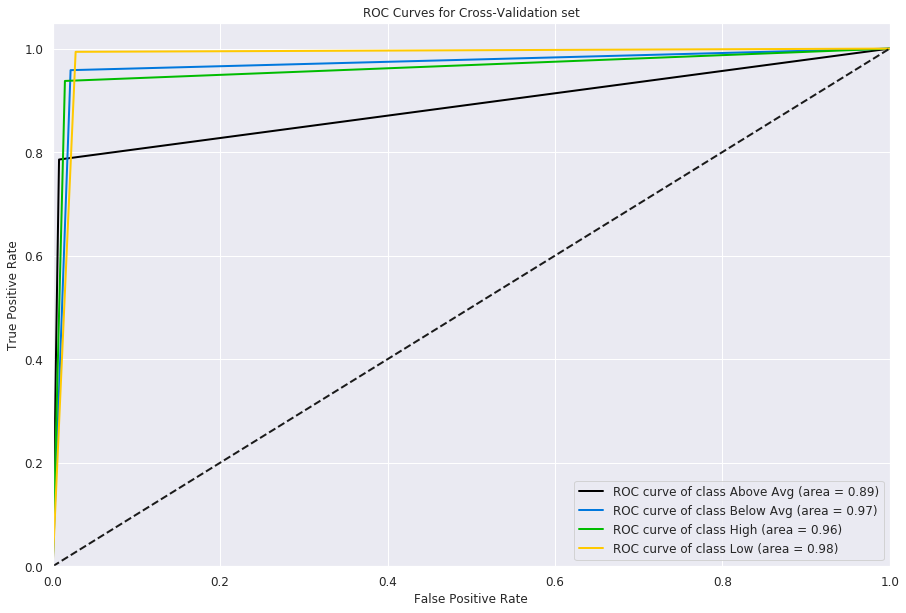

In [107]:
# Plotting ROC curves for Cross-validation set

y_true = y_test
y_probas = probs
plot_roc_curve(y_true, y_probas, curves=['each_class'], figsize=(15,10))
plt.title('ROC Curves for Cross-Validation set')
plt.show()

In [104]:
# Classification report Test set

print(metrics.classification_report(test_lab, y_pred2))

              precision    recall  f1-score   support

   Above Avg       0.84      0.84      0.84       180
   Below Avg       0.93      0.91      0.92       309
        High       0.91      0.89      0.90       136
         Low       0.97      0.99      0.98       687

   micro avg       0.94      0.94      0.94      1312
   macro avg       0.91      0.91      0.91      1312
weighted avg       0.94      0.94      0.94      1312



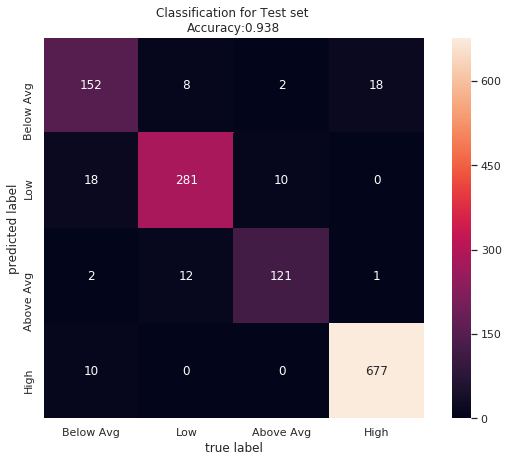

In [106]:
# Plotting confusion matrix for Test set

mat2 = metrics.confusion_matrix(test_lab, y_pred2)
index = ['Below Avg', 'Low', 'Above Avg', 'High']
column = ['Below Avg', 'Low', 'Above Avg', 'High']
mat2 = pd.DataFrame(mat2, index=index, columns=column)

plt.plot()
sns.heatmap(mat2, square=True, annot=True, fmt='d')
plt.title('Classification for Test set \nAccuracy:{0:.3f}'.format(metrics.accuracy_score(test_lab, y_pred2)))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

/home/rajat/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


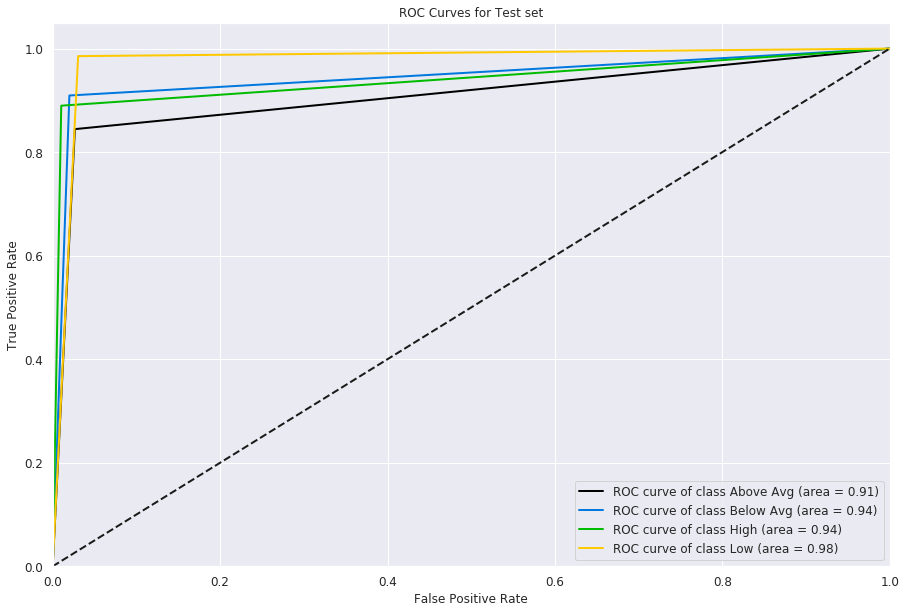

In [108]:
# Plotting ROC curves for Test set

y_true2 = test_lab
y_probas2 = probs2
plot_roc_curve(y_true2, y_probas2, curves=['each_class'], figsize=(15,10))
plt.title('ROC Curves for Test set')
plt.show()